In [1]:
from loveisland.pipeline.get_topics import GetTopics
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import os

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pyLDAvis.sklearn
import datetime as dt 

from loveisland.common.constants import ISLANDERS

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use("bmh")

In [2]:
ISLANDERS = {k: v for k, v in ISLANDERS.items() if v["season"] == 5}

In [3]:
class Arguments():
    bucket = "../data/"
    season = 5
    
args = Arguments()

In [4]:
class DateRange:
    def __init__(self, d0="2019-06-24", d1="2019-07-08"):
        self.d0 = self.fmt_dt(d0)
        self.d1 = self.fmt_dt(d1)
        
        self.dates = self.get_dates()

    @staticmethod
    def fmt_dt(d):
        return dt.datetime.strptime(d, "%Y-%m-%d")

    def get_dates(self):
        delta = self.d1 - self.d0
        return [
            str((self.d0 + dt.timedelta(days=i)).date()) for i in range(delta.days + 1)
        ]

In [5]:
dr = DateRange()

In [7]:
EVENTS = {
    " Third Recoupling \n Yewande Dumped": {"date": "2019-06-24", "color": "Red", "h": 1, "t": 10, "d": 22},
    " Arabella and Tom \n are Dumped": {"date": "2019-06-27", "color": "Red", "h": 1, "t": 3, "d": 25},
    " Casa Amor Begins": {"date": "2019-06-28", "color": "Green", "h": 2, "t": 7, "d": 26},
    " Fourth Recoupling \n Dan, Dennon, Stevie \n Lavena, Maria and Nabila dumped": 
    {"date": "2019-07-02", "color": "Green", "h": 2, "t": 3, "d": 30},
}
for_tl = pd.DataFrame({"date": dr.dates, "filler": 1})

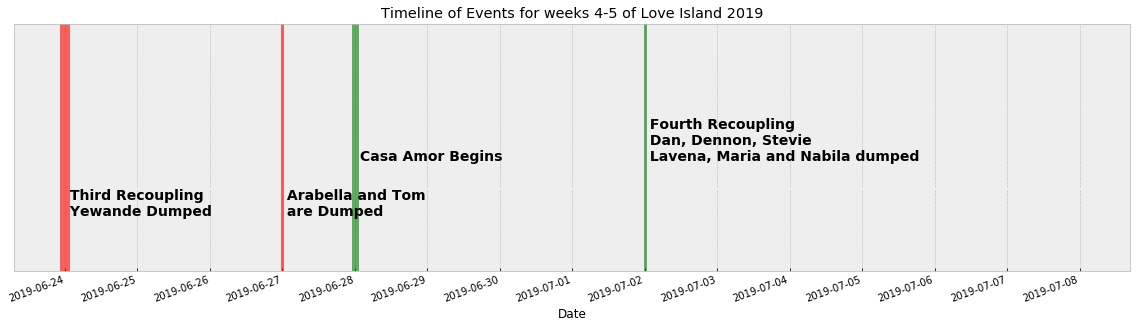

In [8]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)

sns.lineplot(x="date", y="filler", color="#EEEEEE", data=for_tl, ax=ax1)
plt.xticks(rotation=20, ha="right")
ax1.set(xticks=for_tl.date.unique(), yticks=[], xlabel="Date", ylabel="", ylim=(0, 3), 
       title="Timeline of Events for weeks 4-5 of Love Island 2019")

for key, item in EVENTS.items():
    ax1.axvline(item["date"], color=item["color"], linewidth=item["t"], alpha=0.6)
    ax1.text(item["date"], 2 * item["h"] / 3, key, fontsize=14, weight="bold")


In [9]:
class GetInputs:
    def __init__(self, args, dates):
        self.args = args
        self.dates = dates
        self.stored = {}
        self.to_plot = None

    def import_aspects(self, dt):
        """Import model + vocabulary for a given date"""
        path = os.path.join(
            self.args.bucket, "season_" + str(self.args.season), "{}", str(dt) + ".pkl"
        )
        return (
            pickle.load(open(path.format("models"), "rb")),
            pickle.load(open(path.format("vocab"), "rb")),
        )

    def setup_aspects(self, dt, col="processed_text"):
        """Set up all the aspects from the topic modelling we need downstream"""
        gt = GetTopics(self.args, dt)
        gt.import_data()

        mod, vocab = self.import_aspects(dt)

        vectorizer = CountVectorizer(vocabulary=vocab)
        vectorizer._validate_vocabulary()
        A = vectorizer.fit_transform(gt.df[col])
        return gt.df, mod, vectorizer, A, vectorizer.get_feature_names()

    @staticmethod
    def topic_probs(doc_tops, df):
        """Assign the 'most likely' topic for every tweet in the corpus and the probability
        of that tweet being in that topic compared with any others"""

        # df[df["text"].str.contains("pic.twitter.com") == False]
        for_df = []
        for i in range(len(doc_tops)):
            js = {str(j): float(doc_tops[i][j]) for j in range(len(doc_tops[i]))}
            js["processed_text"] = df["processed_text"][i]
            for_df.append(js)

        for_df = pd.melt(
            pd.DataFrame(for_df), id_vars=["processed_text"], var_name="topic"
        )
        for_df["val_max"] = for_df.groupby(["processed_text"])["value"].transform(max)
        for_df = (
            for_df[for_df["value"] == for_df["val_max"]]
            .drop(columns="val_max")
            .reset_index(drop=True)
        )
        df = df.merge(for_df, on="processed_text", how="left").drop_duplicates(
            ["processed_text"]
        )
        df["text"] = df["text"].astype(str)
        return df[~df["text"].str.contains("pic.twitter.com")].reset_index(drop=True)

    def fill(self, dt, df, mod, vectorizer, A, bag_of_words):
        """Fill a dictionary with all the gathered elements for a given date"""
        self.stored[dt] = {
            "df": df,
            "mod": mod,
            "vectorizer": vectorizer,
            "A": A,
            "bag_of_words": bag_of_words,
            "n_tweets": df.url.nunique(),
            "perplexity": mod.perplexity(A),
        }
        return self

    def wrapper(self, dt):
        """Bring all methods together for a given date"""
        df, mod, vectorizer, A, bag_of_words = self.setup_aspects(dt)
        doc_tops = mod.transform(A)
        df = self.topic_probs(doc_tops, df)

        self.fill(dt, df, mod, vectorizer, A, bag_of_words)
        return self

    def get_all(self):
        """Loop over all dates we want to include in analysis"""
        for dt in self.dates:
            self.wrapper(dt)
        return self

    @staticmethod
    def dict_to_df(_dict, col="date"):
        """Transform a dictionary to pandas df"""
        df = pd.DataFrame.from_dict(_dict, orient="index")
        df.index.name = col
        return df.reset_index(drop=False)

    def prep_for_plot(self):
        """Extract relevant columns for a plot"""
        self.to_plot = {
            k: {"n_tweets": v["n_tweets"], "perplexity": v["perplexity"]}
            for k, v in self.stored.items()
        }
        self.to_plot = self.dict_to_df(self.to_plot)
        return self

    def add_params(self):
        """Augment df with parameters used in the topic modelling"""
        params = pickle.load(
            open(
                os.path.join(
                    args.bucket, "season_" + str(args.season), "best_param.pkl"
                ),
                "rb",
            )
        )
        params = self.dict_to_df(params)
        self.to_plot = self.to_plot.merge(params, on="date", how="left")
        self.to_plot["date"] = self.to_plot["date"].astype(str)
        return self


In [11]:
gi = GetInputs(args, ["2019-07-07"])#dr.dates)
gi.get_all().prep_for_plot().add_params()

LDA learning decay is the rate at which old information / weights are forgotten per iteration, ie how much weight does a topic hold after it has been created in relation to a potential new topic. 

file:///Users/samwatson/Downloads/Online_Learning_for_Latent_Dirichlet_Allocation.pdf

One could argue that their is a negative correlation between the number of tweets contained in the corpus and the learning decay (ie the greater the total tweets, the lower the learning decay). This isn't a hugely striking relationship however it does make sense as one would expect a larger range of topics in a larger corpus, especially given the multi-faceted nature of the show and the fact that there are lots of differing story lines per episode that are likely to result in a significant number of tweets each. On the day we saw the most tweets (7th July - the recoupling / ending of Casa Amor), there were 3 of the biggest stories of the show coming to a point (both Anna and Micheal recoupling with new islanders and leaving their original partner single as well as the controversy / drama surrounding Amy and Curtis' relationship). Given this to this one would imagine that the model needed to be more dynamic in changing the weighing of topics and therefore required a lower learning decay than the models performed on tweets from Saturdays when the show is not and and not a lot is spoken about online.  

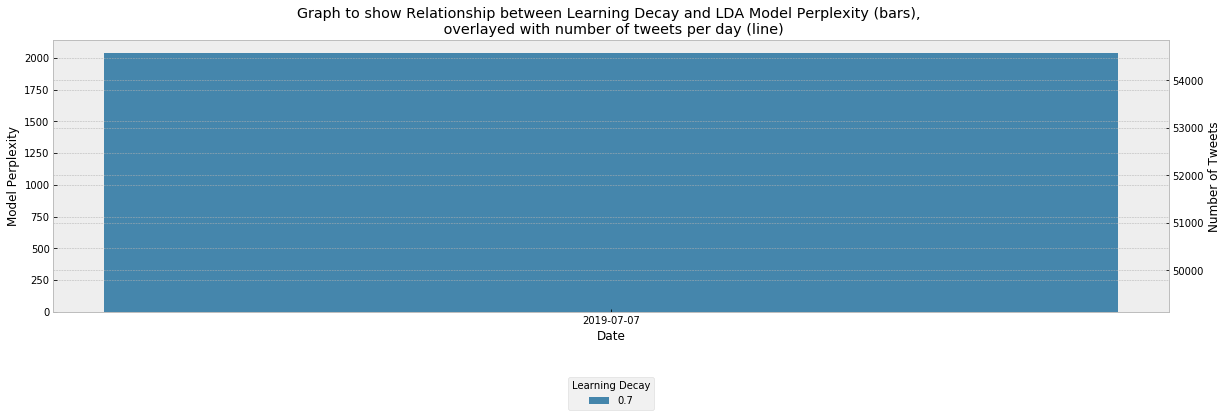

In [12]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

sns.barplot(
    "date", "perplexity", "learning_decay", data=gi.to_plot, dodge=False, ax=ax1
)
ax1.set(
    xlabel="Date",
    ylabel="Model Perplexity",
    title="Graph to show Relationship between Learning Decay and LDA Model Perplexity (bars), \n "
    "overlayed with number of tweets per day (line)",
)

sns.lineplot(x="date", y="n_tweets", color="Blue", data=gi.to_plot, ax=ax2)
ax2.set_ylabel("Number of Tweets")

plt.xticks(rotation=20, ha="right")
ax1.legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=5, title="Learning Decay")


In [13]:
class TopicModFunctions:
    def __init__(self, stored):
        self.stored = stored
        self.pholder = None

    def get_elements(self, dt):
        """Extract"""
        self.pholder = self.stored[dt]
        return self

    def get_terms(self, dt, n_words=10, print_terms=False):
        self.get_elements(dt)

        for_df = []
        for topic_idx, topic in enumerate(self.pholder["mod"].components_):
            terms = [
                self.pholder["bag_of_words"][i]
                for i in topic.argsort()[: -(n_words + 1) : -1]
            ]
            for_df.append({"topic": topic_idx, "terms": terms})
            if print_terms:
                print("Topic", topic_idx, ":", terms)
        return pd.DataFrame(for_df)

    def top_doc(self, dt, sb_col):
        self.get_elements(dt)

        df = (
            self.pholder["df"][self.pholder["df"]["value"] > 0.5]
            .sort_values(by=sb_col, ascending=False)
            .groupby(["topic"])
            .head(1)
            .sort_values(by="topic")
            .reset_index(drop=True)
        )

        print("Top document per topic")

        for i, row in df.iterrows():
            print(
                "Topic {0} (probability={1})".format(
                    row["topic"], round(row["value"], 2)
                ),
                "\nText:",
                row["text"],
                "\n",
            )
            
    def topic_senti(self, dt):
        self.get_elements(dt)
        df = self.pholder["df"]
        
        means = df.groupby("topic")["score"].mean().reset_index(name="topic_mean_senti")
        means['colour'] = np.where(means["topic_mean_senti"] > 0, "Positive", "Negative")
        return df.merge(means, on="topic", how="left")

In [14]:
tmf = TopicModFunctions(gi.stored)

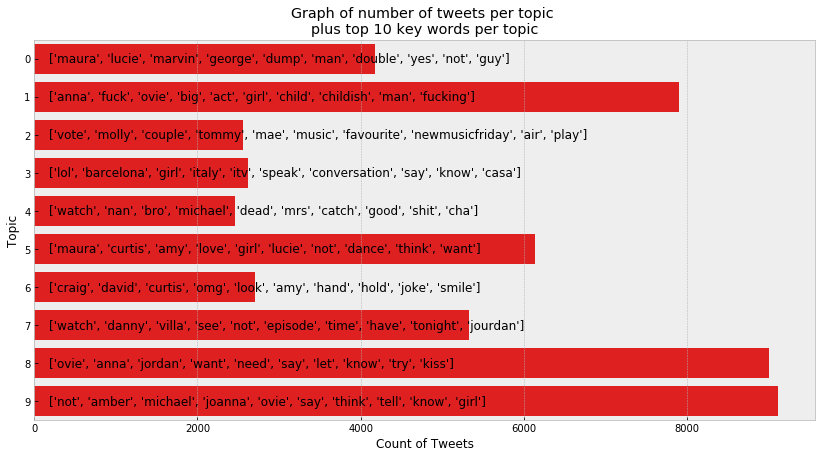

In [17]:
terms = tmf.get_terms("2019-07-07")

df = tmf.pholder["df"].groupby("topic")["value"].count().reset_index(name="count")
df["topic"] = df["topic"].astype(int)

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(111)

sns.barplot(x="count", y="topic", data=df, color="Red", ax=ax1, orient="h")

for i, row in terms.iterrows():
    ax1.annotate(
        row["terms"],
        xy=(0, 0),
        xytext=(df["count"].max() / 50, i + 0.1),
        color="Black",
        fontsize=12,
    )

ax1.set(
    xlabel="Count of Tweets",
    ylabel="Topic",
    title="Graph of number of tweets per topic \nplus top 10 key words per topic",
);

Top tweet per topic based on the probability of the tweet being in each topic. Probability is the likelihood of the tweet being in each topic, therefore each tweet has a probability per topic with these summing to one. As we can see, when we pick the tweet with the highest probability of being in each topic they seem fairly random given the corpus, we know the the algorithm finds the probability on a word by word basis, therefore the more key words per topic a text has the more likely it is to be in that topic. We also know that the probability is based on likelihood of being in each topic in comparison to each of the other topics, therefore if a tweet has a keyword from topic 0 and no words match any key words from any other topics, the algorithm places a very high probability of this tweet being in this topic even though it is seemingly very random. 


In light of this, to address the fact that this isnt that useful in the real world, we can filter out tweets with less than a 60% probability of being related with a topic and then pull out the most popular in terms of favourites on twitter, we would expect this tweet to not only be about love island and therefore would have to have a lot of key words to be assigned such a high probability but also be very relevant to the topic itself due to recieving a lot of likes. 

In [18]:
tmf.top_doc("2019-07-07", "value")

Top document per topic
Topic 0 (probability=0.97) 
Text: Auf 'Love Island' werden Gerichte von Arielle Vandenberg in der lustvollen Atmosphäre der Show serviert https://www.nach-welt.com/unterhaltung/auf-love-island-werden-gerichte-von-arielle-vandenberg-in-der-lustvollen-atmosphare-der-show-serviert/ … 

Topic 1 (probability=0.97) 
Text: Re: Love Island. STOP MAKING STUPID PEOPLE FAMOUS STOP MAKING STUPID PEOPLE FAMOUS STOP MAKING STUPID PEOPLE FAMOUS STOP MAKING STUPID PEOPLE FAMOUS STOP MAKING STUPID PEOPLE FAMOUS STOP MAKING STUPID PEOPLE FAMOUS STOP MAKING STUPID PEOPLE FAMOUS 

Topic 2 (probability=0.96) 
Text: Now on air : Sigala & Ella Eyre & Meghan Trainor feat French Montana - Just Got Paid Follow & Retweet to keep your Fav music playing # Hitmusic # NewMusicFriday # music # soundcloud # newmusic # newmusicfriday # spotify @ officialcharts @ BRITs # LoveIsland 

Topic 3 (probability=0.98) 
Text: CNN Poll: Overwhelming Majority Wants Investigation into Obama DOJ Spying on Trum

In [19]:
tmf.top_doc("2019-07-07", "favs")

Top document per topic
Topic 0 (probability=0.56) 
Text: Craic David going into the villa, Maura gonna try couple up with him... # loveisland 

Topic 1 (probability=0.52) 
Text: I am sorry but I am team Ovie Calling him a child is she joking # loveisland 

Topic 2 (probability=0.77) 
Text: PLEASE. TURN. THE MICS. DOWN. WHEN. THEY’RE. KISSING # LoveIsland 

Topic 3 (probability=0.52) 
Text: love island stands undefeated https://twitter.com/itv2/status/1147601996431708161 … 

Topic 4 (probability=0.51) 
Text: Girls go careful you see what happens when you learn a little cha cha cha from a professional..... ballroom dancer # loveisland 

Topic 5 (probability=0.71) 
Text: i discovered ‘Love Island’ the other day and it’s safe to say the little social life i had is now over 

Topic 6 (probability=0.55) 
Text: OVIE BASICALLY SAID “JORDAN GO FEED UR BADDERZ PASTA” # LoveIsland 

Topic 7 (probability=0.73) 
Text: decided to get my life together and start a 5 year plan: Year 1: get a nose job Y

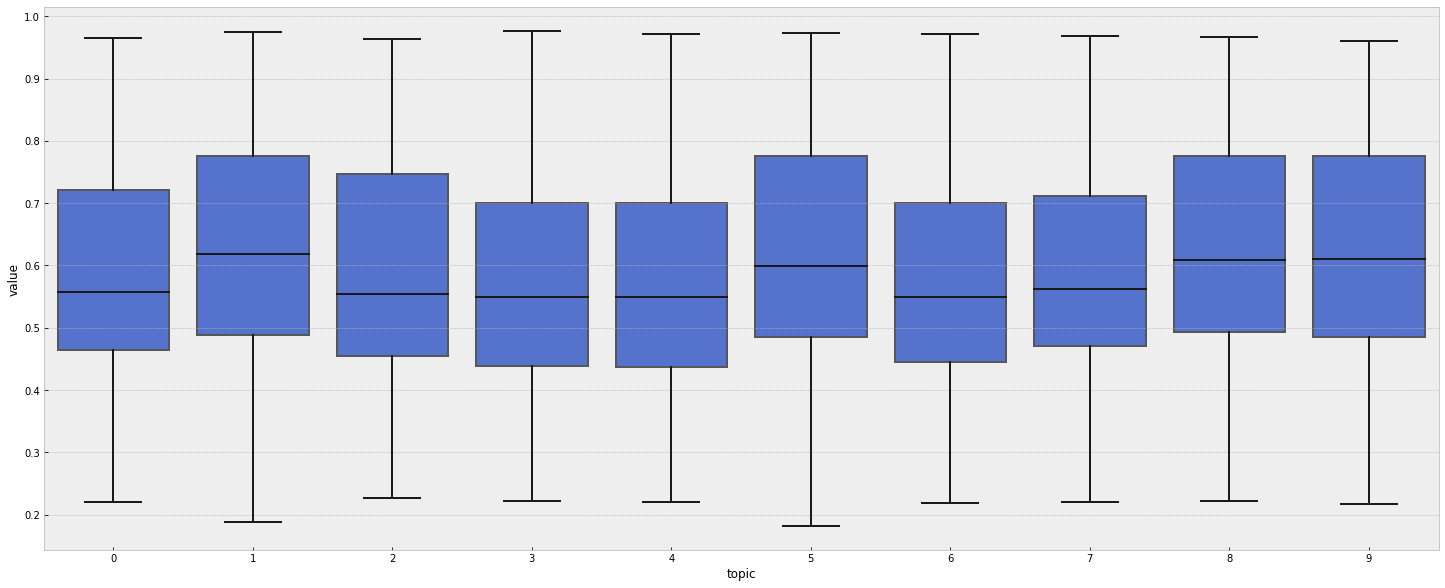

In [20]:
tmf.get_elements("2019-07-07")

fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(111)

sns.boxplot(x="topic", y="value", data=tmf.pholder["df"], color="royalblue", ax=ax1)
plt.setp(ax1.lines, color=".1");

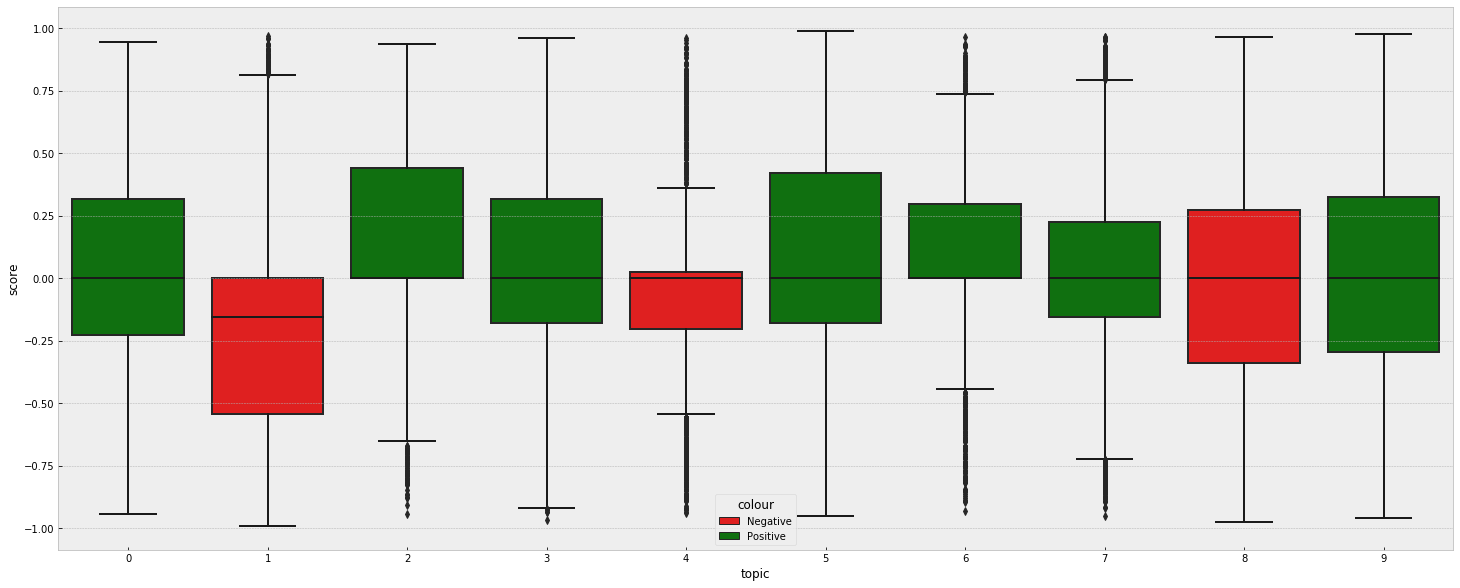

In [21]:
df = tmf.topic_senti("2019-07-07")

fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(111)

sns.boxplot(
    "topic",
    "score",
    "colour",
    data=df,
    ax=ax1,
    dodge=False,
    palette={"Negative": "Red", "Positive": "Green"},
)
plt.setp(ax1.lines, color=".1");

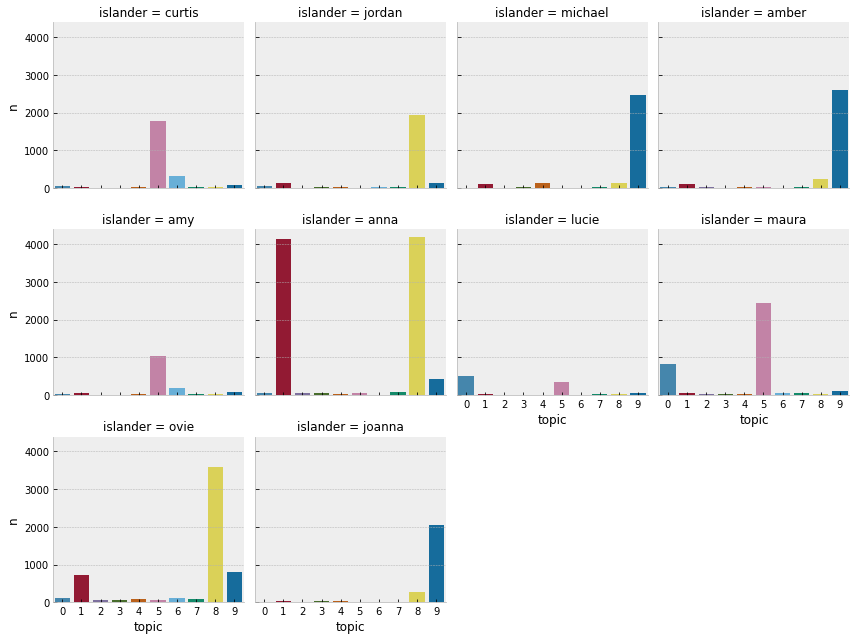

In [39]:
tmf.get_elements("2019-07-07")

df = tmf.pholder["df"]
df = df[df["value"] > 0.5]

full = pd.DataFrame()
for islander in ISLANDERS:
    temp = df[df[islander] == islander].groupby("topic")["url"].count().reset_index(name="n")
    temp["islander"] = islander
    
    if temp.n.sum() > 1000:
        full = full.append(temp, sort=True)

order = full.topic.unique()
g = sns.FacetGrid(col="islander", col_wrap=4, data=full, hue="topic")
g.map(sns.barplot, "topic", "n", dodge=True, order=order)